<a href="https://colab.research.google.com/github/ActiveStacks/AI_with_PyTorch/blob/main/BertClassificationTutrorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [56]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [57]:
import pandas as pd
from sklearn.model_selection import train_test_split

In [58]:
path = ('/content/drive/MyDrive/XSS_dataset.csv')


In [59]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


In [60]:
!pip install transformers

In [61]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import shutil
import sys


In [62]:
path = "/content/drive/MyDrive/XSS_dataset.csv"
df = pd.read_csv(path)

In [88]:
df.head()
print(df.columns)


Index(['Sentence', 'Label'], dtype='object')


In [89]:
print(df.index)

RangeIndex(start=0, stop=13686, step=1)


In [64]:
df=df.drop(['Unnamed: 0'], axis=1)

In [65]:
df.head()

,Sentence,Label
0,"<li><a href=""/wiki/File:Socrates.png"" class=""i...",0
1,"<tt onmouseover=""alert(1)"">test</tt>",1
2,"\t </span> <span class=""reference-text"">Steeri...",0
3,"\t </span> <span class=""reference-text""><cite ...",0
4,"\t </span>. <a href=""/wiki/Digital_object_iden...",0


In [66]:
labels = df['Label'].unique().tolist()
labels

[0, 1]

In [67]:
for key, value in enumerate(labels):
  print(key)

0
1


In [68]:
NUM_LABELS = len(labels)
NUM_LABELS

2

In [69]:
id2label = {id:label for id, label in enumerate(labels)}
label2id = {label:id for id, label in enumerate(labels)}

<Axes: ylabel='count'>

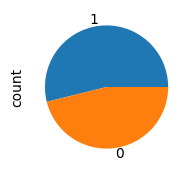

In [45]:
df.Label.value_counts().plot(kind='pie',figsize=(2,2))

In [46]:
train_val, test_data = train_test_split(df, test_size=0.2, random_state=42)

In [47]:
train_data, val_data = train_test_split(train_val, test_size=0.25, random_state=42)

In [90]:
print(train_data.columns)

Index(['Sentence', 'Label'], dtype='object')


In [91]:
print(train_data.index)

Index([ 9421,  6258,  4373,   312,  6083, 12106,  5148,  4520,  8053,  8019,
       ...
        1638,  2537,  5137, 13557, 10858, 13230,  1564,  3395,  6552,  9959],
      dtype='int64', length=8211)


In [92]:
print(val_data.index)

Index([13225,  6698, 13035,  3413, 12366,  3269,  1699,   617,  2090,  7242,
       ...
        8902,  7266,  6487,  8129, 11446,  6197, 11738, 12548, 12624,   106],
      dtype='int64', length=2737)


In [100]:
key = 6104
if key in df.columns:
    print("Column exists")
elif key in df.index:
    print("Index exists")
else:
    print("Key does not exist")

Index exists


In [48]:
train_data.head()

,Sentence,Label
9421,<svg><picture onload=alert(1)></picture>,1
6258,<textarea id=x tabindex=1 ondeactivate=alert(1...,1
4373,\t </span> 2007,0
312,"<li id=""cite_note-393""><span class=""mw-cite-ba...",0
6083,"<li><a href=""/wiki/Erich_von_Holst"" title=""Eri...",0


In [70]:
target_list = ['Label']

In [71]:
test_data.head()

,Sentence,Label
4104,"<plaintext onmouseup=""alert(1)"">test</plaintext>",1
9185,"<div draggable=""true"" contenteditable>drag me<...",1
450,<basefont onfocusout=alert(1) tabindex=1 id=x>...,1
11615,"\t </span> <span class=""reference-text"">Mark C...",0
9364,Classical planning:,0


In [72]:
val_data.head()

,Sentence,Label
13225,<thead onpointerup=alert(1)>XSS</thead>,1
6698,"\t </span><span class=""mw-editsection""><span c...",0
13035,"<li><a href=""/wiki/Auguste_Comte"" title=""Augus...",0
3413,"<div draggable=""true"" contenteditable>drag me<...",1
12366,"<em onmouseenter=""alert(1)"">test</em>",1


In [73]:
MAX_LEN = 256
TRAIN_BATCH_SIZE = 32
VAL_BATCH_SIZE = 32
EPOCHS = 2
LEARNING_RATE = 1e-05

In [74]:
from transformers import BertTokenizer, BertModel

In [75]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

In [25]:
# example_text = "<thead onpointerup=alert(1)>XSS</thead>	"
# encodings =tokenizer.encode_plus(
#     example_text,
#     add_special_tokens=True,
#     max_length=MAX_LEN,
#     padding='max_length',
#     truncation=True,
#     return_attention_mask=True,
#     return_tensors='pt'
# )

In [26]:
# encodings

In [76]:
class CustomDataset(torch.utils.data.Dataset):

  def __init__(self, df, tokenizer, max_len):
    self.tokenizer = tokenizer
    self.df = df
    self.title = df['Sentence']
    self.targets = self.df[target_list].values
    self.max_len = max_len

  def __len__(self):
      return len(self.title)

  def __getitem__(self, index):
      title = str(self.title[index])
      title = " ".join(title.split())

      inputs = self.tokenizer.encode_plus(
          title,
          None,
          add_special_tokens = True,
          max_length=self.max_len,
          padding='max_length',
          return_token_type_ids=True,
          truncation=True,
          return_attention_mask=True,
          return_tensors='pt'
      )

      return {
        'input_ids' : inputs['input_ids'].flatten(),
        'attention_mask':  inputs['attention_mask'].flatten(),
        'token_type_ids': inputs['token_type_ids'].flatten(),
        'targets': torch.FloatTensor(self.targets[index])
      }





In [28]:
# train_data['Sentence'][2]

In [77]:
train_dataset = CustomDataset(train_data, tokenizer, MAX_LEN)
val_dataset = CustomDataset(val_data, tokenizer, MAX_LEN)

In [78]:
train_dataloader = torch.utils.data.DataLoader(
    train_dataset,
    shuffle=True,
    batch_size=TRAIN_BATCH_SIZE,
    num_workers=0
)

In [79]:
val_dataloader = torch.utils.data.DataLoader(
    val_dataset,
    shuffle=True,
    batch_size=VAL_BATCH_SIZE,
    num_workers=0
)

In [80]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cpu


In [81]:
def load_ckp(checkpoint_fpath, model, optimizer):
  checkpoint = torch.load(checkpoint_fpath)
  model.load_state_dict(checkpoint['state_dict'])
  optimizer.load_state_dict(checkpoint['optimizer'])
  valid_loss_min = checkpoint['valid_loss_min']
  return model, optimizer, checkpoint['epoch'], valid_loss_min.item()

In [82]:
def save_ckp(state, is_best, checkpoint_path, best_model_path):
  f_path = checkpoint_path
  torch.save(state, f_path)
  if is_best:
    best_path = best_model_path
    shutil.copyfile(f_path, best_fpath)

In [83]:
class BERTClass(torch.nn.Module):
  def __init__(self):
     super(BERTClass, self).__init__()
     self.bert_model = BertModel.from_pretrained('bert-base-uncased', return_dict=True)
     self.dropout = nn.Dropout(0.3)
     self.linear = nn.Linear(768,2)

  def forward(self, input_ids, attention_mask, return_token_type_ids):
     output = self.bert_model(input_ids, attention_mask, token_type_ids)
     output_dropout = self.dropout(output.pooler_output)
     output=self.linear(output_dropout)
     return output
model = BERTClass()
model.to(device)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

BERTClass(
  (bert_model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwi

In [84]:
def loss_fn(outputs, targets):
  return nn.BCEWithLogitsLoss()(outputs, targets)

optimizer = torch.optim.Adam(params=model.parameters(),lr=LEARNING_RATE)

In [85]:
# TRAINING LOOP
def train_model(
    n_epochs,
    training_loader,
    validation_loader,
    model,
    optimizer,
    checkpoint_path,
    best_model_path
):

   valid_loss_min=np.Inf

   for epoch in range(1, n_epochs+1):
     train_loss=0
     valid_loss=0

     model.train()
      #  TRAINING LOOP
     for index, batch in enumerate(training_loader):
         input_ids=batch['input_ids'].to(device, dtype=torch.long)
         attention_mask = batch['attention_mask'].to(device, dtype=torch.long)
         token_type_ids = batch['token_type_ids'].to(device, dtype=torch.long)
         targets = batch['targets'].to(device, dtype=torch.float)
         outputs=model(input_ids, attention_mask, token_type_ids)
         optimizer.zero_grad()
         loss=loss_fn(outputs, targets)
         optimizer.zero_grad()
         loss_backward()
         optimizer.step()
         train_loss=train_loss + (1/(index+1)(loss.item()-train_loss))

      #  VALIDATION LOOP

     model.eval()

     with torch.no_grad():
       for index, batch in enumerate(validation_loader):
            input_ids=batch['input_ids'].to(device, dtype=torch.long)
            attention_mask = batch['attention_mask'].to(device, dtype=torch.long)
            token_type_ids = batch['token_type_ids'].to(device, dtype=torch.long)
            targets = batch['targets'].to(device, dtype=torch.float)
            outputs=model(input_ids, attention_mask, token_type_ids)
            loss=loss_fn(outputs, targets)
            optimizer.step()
            val_loss=val_loss + (1/(index+1)(loss.item()-val_loss))


       checkpoint = {
          'epoch': epoch + 1,
          'valid_loss_min': valid_loss,
          'state_dict' : model.state_dict(),
          'optimizer' : optimizer.state_dict()
       }

       save_ckp(checkpoint, False, checkpoint_path, best_model_path)

   return model



In [86]:
trained_model = train_model(EPOCHS, train_dataloader, val_dataloader, model, optimizer, "/curr_ckpt", "/best.pt")

KeyError: 6104